# Compare HDF5 and Hub
Author: Margaux Masson-Forsythe

# Imports

In [ ]:
!pip install hub==2.0.9

In [ ]:
import os

import string
import random
import h5py
import os
import hub
import numpy as np
from tqdm import tqdm
from time import time
from functools import wraps
import matplotlib.pyplot as plt
from IPython.display import Image, clear_output
import glob
import cv2

In [ ]:
print(hub.__version__)

2.0.9


# Load dataset: [Animals](https://www.kaggle.com/alessiocorrado99/animals10)
Animal pictures of 10 different categories taken from google images
Contains about 28K medium quality animal images belonging to 10 categories: dog, cat, horse, spyder, butterfly, chicken, sheep, cow, squirrel, elephant.



In [ ]:
!export KAGGLE_USERNAME="xxxxxxxx" && export KAGGLE_KEY="xxxxxxx" && kaggle datasets download -d alessiocorrado99/animals10

 99% 581M/586M [00:04<00:00, 147MB/s]
100% 586M/586M [00:04<00:00, 145MB/s]


In [ ]:
!unzip -n animals10.zip
clear_output()

In [ ]:
!rm -r animals10.zip

In [ ]:
dataset_animals = './raw-img'
file_names = glob.glob(dataset_animals + '/**/*.jpeg')

print(f'There are {len(file_names)} images in the dataset')

class_names = os.listdir(dataset_animals)
print(f'This dataset has {len(class_names)} classes: {class_names}')

There are 24209 images in the dataset
This dataset has 10 classes: ['mucca', 'elefante', 'ragno', 'farfalla', 'gatto', 'pecora', 'gallina', 'scoiattolo', 'cane', 'cavallo']


Shape image: (222, 300, 3)
Label image: cavallo


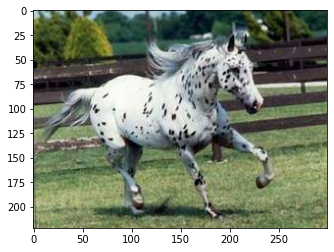

Shape image: (157, 300, 3)
Label image: elefante


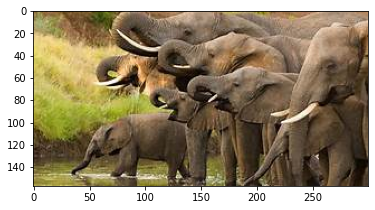

Shape image: (200, 300, 3)
Label image: gatto


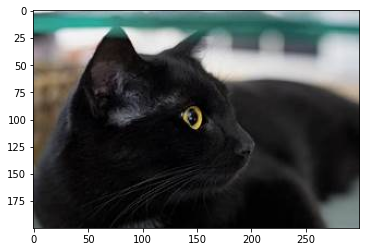

Shape image: (200, 300, 3)
Label image: cane


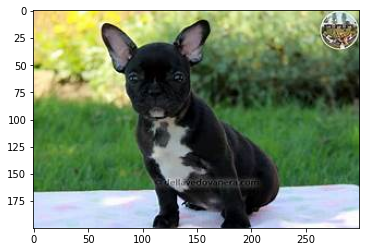

In [ ]:
import random

# List of 4 random images indexes to visualize in the dataset
list_random_indexes = [random.randint(0,len(file_names)) for i in range(4)]

for i in list_random_indexes:
  # cv2 reads the images in BRG so we use cvtColor to convert them to RGB
  train_img = cv2.cvtColor(cv2.imread(file_names[i]), cv2.COLOR_BGR2RGB)
  print(f'Shape image: {train_img.shape}')
  label_text = os.path.basename(os.path.dirname(file_names[i]))
  print(f'Label image: {label_text}')


  plt.imshow(train_img)
  plt.show()

# HDF5

In [ ]:
def timeit(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        start = time()
        result = func(*args, **kwargs)
        end = time()
        print(f'{func.__name__} executed in {end - start:.4f} seconds')
        return result, end - start

    return wrapper

In [ ]:
!mkdir datasets

HDF5 one dataset per image

In [ ]:
dataset_h5_path = "./datasets/animals-10-hdf5"

@timeit
def create_hdf5_dataset(file_names):
  with h5py.File(f'./{dataset_h5_path}.h5', 'w') as hf:
      for i in tqdm(range(len(file_names))):
          # cv2 reads the images in BGR so we convert them to RGB
          image = cv2.cvtColor(cv2.imread(file_names[i]), cv2.COLOR_BGR2RGB)
          hf.create_dataset(str(i), data=image)
  return hf

hf = create_hdf5_dataset(file_names)

100%|██████████| 24209/24209 [00:47<00:00, 514.01it/s]

create_hdf5_dataset executed in 47.1463 seconds


Sequential access

In [ ]:
n_images_to_load = 100

@timeit
def hdf_load(k, hf):
    print([hf[str(i)] for i in range(k)])

hdf_time_seq_access = []
hf = h5py.File(f'./{dataset_h5_path}.h5', "r") 
# Sequential access 0 to 100 indexes
for k in tqdm(range(n_images_to_load)):
  hdf_time_seq_access.append(hdf_load(k, hf)[1])
clear_output()

Random access

In [ ]:
@timeit
def hdf_load(k, hf):
    print([hf[str(i)] for i in range(k)])

hdf_time_random_access = []
hf = h5py.File(f'./{dataset_h5_path}.h5', "r") 
# Random access: 100 indexes between 0 and 1000 with a step of 10 between each index
for k in tqdm(range(0, 1000, 10)):
  hdf_time_random_access.append(hdf_load(k, hf)[1])
clear_output()

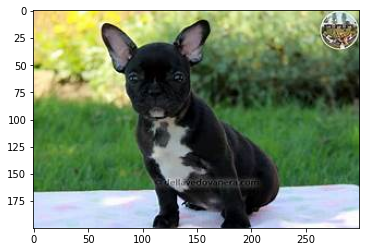

In [ ]:
plt.imshow(hf[str(i)])

HDF5 only two datasets images and labels

In [ ]:
dataset_h5_images_labels_path = "./datasets/animals-10-img-labels-hdf5"

@timeit
def hdf5_dataset():
  # Gathering all images and labels in lists to be stored in the hf dataset in separate datasets
  images = []
  labels = []

  for i in tqdm(range(len(file_names))):
    image = cv2.cvtColor(cv2.imread(file_names[i]), cv2.COLOR_BGR2RGB)
    # images need to be resize for the creation of the hdf5 dataset "images"
    image = cv2.resize(image, (256,256))
    images.append(image)
    label_text = os.path.basename(os.path.dirname(file_names[i]))
    label_num = class_names.index(label_text)
    labels.append(label_num)

  # Create the hdf5 dataset
  with h5py.File(f'./{dataset_h5_images_labels_path}.h5', 'w') as hf:
    images_h5_dataset = hf.create_dataset("images", np.shape(images), data=images)
    labels_h5_dataset = hf.create_dataset("labels", np.shape(labels), data=labels)

hdf5_dataset()

100%|██████████| 24209/24209 [00:42<00:00, 569.56it/s]


hdf5_dataset executed in 74.9684 seconds


(None, 74.96839952468872)

Sequential access

In [ ]:
@timeit
def hdf_load(k, hf):
    print([hf['images'][i] for i in range(k)])
    print([hf['labels'][i] for i in range(k)])

hdf_time_seq_access_img_label = []
hf = h5py.File(f'./{dataset_h5_images_labels_path}.h5', "r") 
# Sequential access 0 to 100 indexes
for k in tqdm(range(n_images_to_load)):
  hdf_time_seq_access_img_label.append(hdf_load(k, hf)[1])
clear_output()

Random access

In [ ]:
@timeit
def hdf_load(k, hf):
    print([hf['images'][i] for i in range(k)])
    print([hf['labels'][i] for i in range(k)])

hdf_time_random_access_img_label = []
hf = h5py.File(f'./{dataset_h5_images_labels_path}.h5', "r") 
# Random access: 100 indexes between 0 and 1000 with a step of 10 between each index
for k in tqdm(range(0,1000,10)):
  hdf_time_random_access_img_label.append(hdf_load(k, hf)[1])
clear_output()

# Hub

In [ ]:
dataset_hub_path = "./datasets/animals-10-hub"

@timeit
def create_hub_dataset(dataset_path, file_names):
  with hub.empty(dataset_path, overwrite=True) as ds:
      # Create the tensors with names of your choice.
      ds.create_tensor('images')
      ds.create_tensor('labels')
      
      # Iterate through the files and append to hub dataset
      for file in tqdm(file_names):
          label_text = os.path.basename(os.path.dirname(file))
          label_num = class_names.index(label_text)
          
          ds.images.append(cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB))  # Append to images tensor using cv2 imread
          ds.labels.append(np.uint32(label_num)) # Append to labels tensor
                  
ds = create_hub_dataset(dataset_hub_path, file_names)

100%|██████████| 24209/24209 [01:14<00:00, 323.77it/s]


create_hub_dataset executed in 75.2252 seconds


Sequential access

In [ ]:
@timeit
def hub_load(k, hf):
    print([ds.images[i] for i in range(k)])
    print([ds.labels[i] for i in range(k)])

hub_time_seq_access = []
ds = hub.load(dataset_hub_path)
# Sequential access 0 to 100 indexes
for k in tqdm(range(n_images_to_load)):
  hub_time_seq_access.append(hub_load(k, ds)[1])
clear_output()

Random access

In [ ]:
@timeit
def hub_load(k, hf):
    print([ds.images[i] for i in range(k)])
    print([ds.labels[i] for i in range(k)])

hub_time_random_access = []
ds = hub.load(dataset_hub_path)
# Random access: 100 indexes between 0 and 1000 with a step of 10 between each index
for k in tqdm(range(0, 1000, 10)):
  hub_time_random_access.append(hub_load(k, ds)[1])
clear_output()

mucca


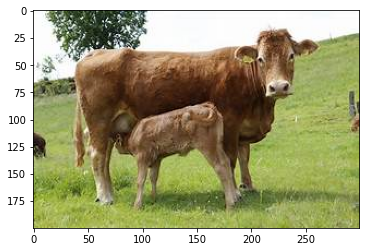

In [ ]:
ds = hub.load(dataset_hub_path)
print(class_names[ds.labels[0].numpy()[0]])
plt.imshow(ds.images[0].numpy())

# Compare incremental image loading from the datasets on local disk

Text(0.5, 1.0, 'Hub versus HDF vs HDF organized in two datasets on local disk -- sequential access')

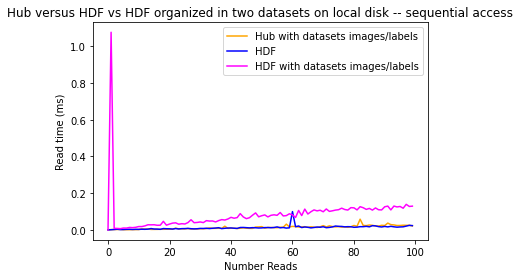

In [ ]:
plt.plot(range(n_images_to_load), hub_time_seq_access, color='orange')
plt.plot(range(n_images_to_load), hdf_time_seq_access, color='blue')
plt.plot(range(n_images_to_load), hdf_time_seq_access_img_label, color='magenta')
plt.legend(['Hub with datasets images/labels', 'HDF', 'HDF with datasets images/labels'])

plt.xlabel('Number Reads')
plt.ylabel('Read time (ms)')
plt.title("Hub versus HDF vs HDF organized in two datasets on local disk -- sequential access")

Text(0.5, 1.0, 'Hub versus HDF on local disk -- Sequential access')

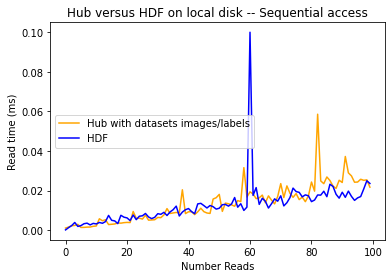

In [ ]:
plt.plot(range(n_images_to_load), hub_time_seq_access, color='orange')
plt.plot(range(n_images_to_load), hdf_time_seq_access, color='blue')
plt.legend(['Hub with datasets images/labels', 'HDF'])

plt.xlabel('Number Reads')
plt.ylabel('Read time (ms)')
plt.title("Hub versus HDF on local disk -- Sequential access")

Text(0.5, 1.0, 'Hub versus HDF vs HDF organized in two datasets on local disk -- Random access')

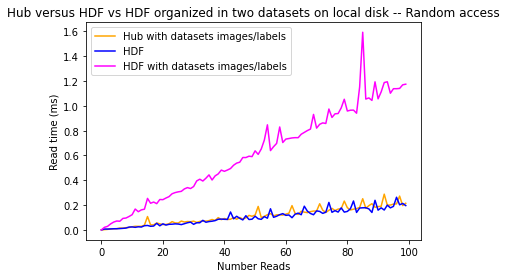

In [ ]:
plt.plot(range(n_images_to_load), hub_time_random_access, color='orange')
plt.plot(range(n_images_to_load), hdf_time_random_access, color='blue')
plt.plot(range(n_images_to_load), hdf_time_random_access_img_label, color='magenta')
plt.legend(['Hub with datasets images/labels', 'HDF', 'HDF with datasets images/labels'])

plt.xlabel('Number Reads')
plt.ylabel('Read time (ms)')
plt.title("Hub versus HDF vs HDF organized in two datasets on local disk -- Random access")

Text(0.5, 1.0, 'Hub versus HDF on local disk -- Random access')

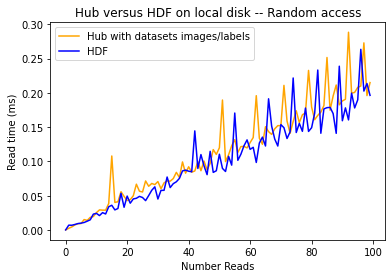

In [ ]:
plt.plot(range(n_images_to_load), hub_time_random_access, color='orange')
plt.plot(range(n_images_to_load), hdf_time_random_access, color='blue')
plt.legend(['Hub with datasets images/labels', 'HDF'])

plt.xlabel('Number Reads')
plt.ylabel('Read time (ms)')
plt.title("Hub versus HDF on local disk -- Random access")

In [ ]:
!du -a datasets | sort -n -r | head -n 5

14037132	datasets
4698208	datasets/animals-10-hdf5.h5
4690596	datasets/animals-10-hub
4690468	datasets/animals-10-hub/images
4690448	datasets/animals-10-hub/images/chunks
